# <center> SCDFXIBM Innovation Challenge </center> 
## - Use YOLOv3 to detect fire and people
## - Input: Video or Image
## - Output: Labeled Video/Image with Number of Detections 
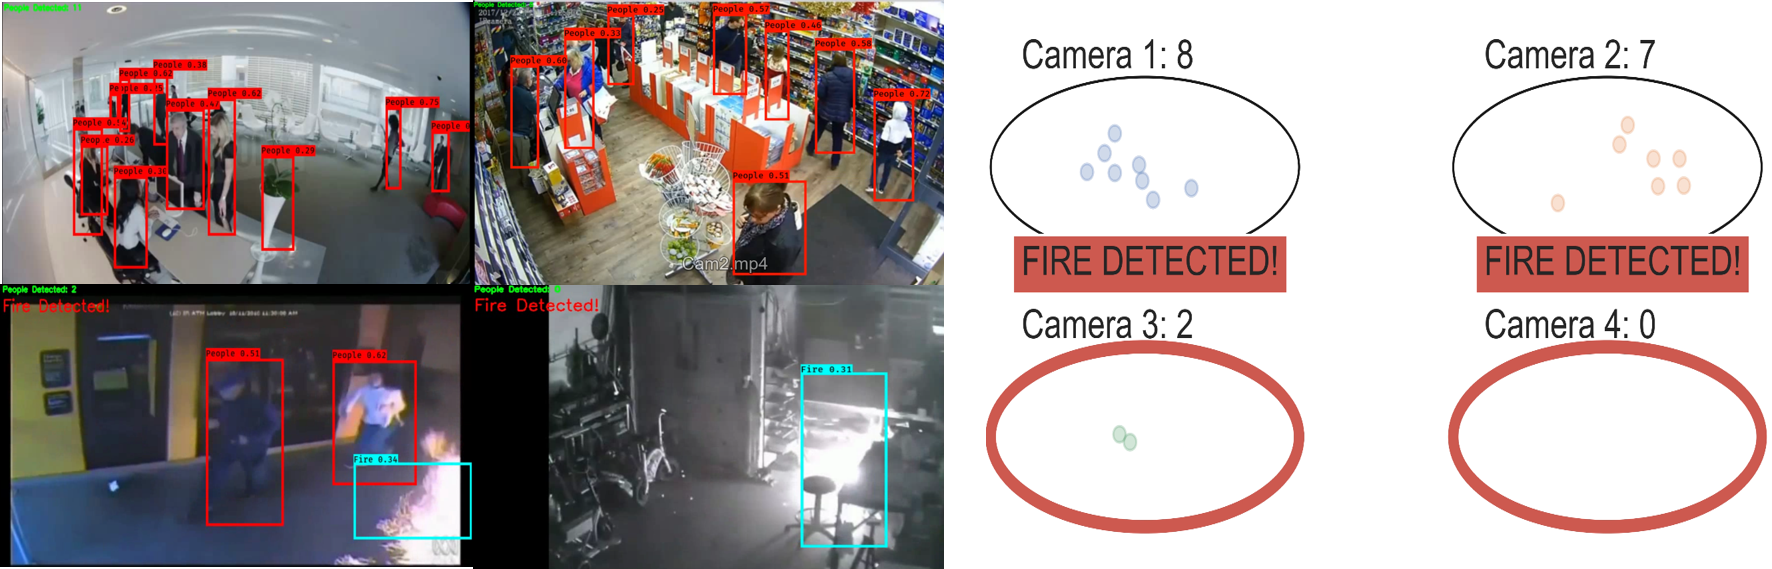

### 1. This First Cell Imports YoloV3 Dependencies

In [2]:
import os
import sys
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
def get_parent_dir(n=1):
    """ returns the n-th parent dicrectory of the current
    working directory """
    current_path = os.path.dirname(os.path.abspath(''))
#     current_path=os.getcwd()
    for k in range(n):
        current_path = os.path.dirname(current_path)
    return current_path


src_path = os.path.join(os.getcwd(), "2_Training", "src")
utils_path = os.path.join(os.getcwd(), "Utils")

sys.path.append(src_path)
sys.path.append(utils_path)

import argparse
from keras_yolo3.yolo import YOLO, detect_video
from PIL import Image
from timeit import default_timer as timer
from utils import load_extractor_model, load_features, parse_input, detect_object
import test
import utils
import pandas as pd
import numpy as np
from Get_File_Paths import GetFileList
import random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

data_folder = os.path.join(os.getcwd(), "Data")

image_folder = os.path.join(data_folder, "Source_Images")

image_test_folder = os.path.join(image_folder, "Test_Images")

detection_results_folder = os.path.join(os.getcwd(), "Test_Image_Detection_Results")
detection_results_file = os.path.join(detection_results_folder, "Detection_Results.csv")

model_folder = os.path.join(data_folder, "Model_Weights")

model_weights = os.path.join(model_folder, "trained_weights_final.h5")
# model_weights=".\\2_Training\\src\\keras_yolo3\\yolo.h5"
model_classes = os.path.join(model_folder, "data_classes.txt")
# model_classes = ".\\2_Training\\src\\keras_yolo3\model_data\\data_classes.txt"

anchors_path = os.path.join(src_path, "keras_yolo3", "model_data", "yolo_anchors.txt")

FLAGS = None

print(model_weights)
print(model_classes)

1 Physical GPUs, 1 Logical GPUs
C:\Users\Chan\OneDrive - Nanyang Technological University\Hackathons\Templates\3. Object Detection Template\Files For Upload\Data\Model_Weights\trained_weights_final.h5
C:\Users\Chan\OneDrive - Nanyang Technological University\Hackathons\Templates\3. Object Detection Template\Files For Upload\Data\Model_Weights\data_classes.txt


### 2. The YOLOv3 Model is built here

In [3]:
yolo = YOLO(
    **{
        "model_path": model_weights,
        "anchors_path": anchors_path,
        "classes_path": model_classes,
        "score": 0.25, #threshold for detection
        "gpu_num": 1,
        "model_image_size": (416, 416),
    }
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
C:\Users\Chan\OneDrive - Nanyang Technological University\Hackathons\Templates\3. Object Detection Template\Files For Upload\Data\Model_Weights\trained_weights_final.h5 model, anchors, and classes loaded in 20.84sec.


### 3. This Cell Reads the Labels

In [4]:
class_file = open(model_classes, "r")
input_labels = [line.rstrip("\n") for line in class_file.readlines()]
print("Found {} input labels: {} ...".format(len(input_labels), input_labels))

Found 2 input labels: ['Fire', 'People'] ...


### 4. Now we are ready to Label Images
### - This cell defines a function to return a dataframe which can be uploaded to IBMCloud later

In [5]:
import cv2
import matplotlib.pyplot as plt
def label_image(name,savename="labeled.png"):
    image = Image.open(os.getcwd()+"\\"+name)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_array = np.array(image)
    
    out_prediction, image ,count_mask,fire_count = yolo.detect_image(image)
    
    
    image=cv2.putText(
    np.asarray(image),
    text="No People Detected : "+ str(count_mask),
    org=(5, 25),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=1,
    color=(0, 255, 0),
    thickness=2)
    
    if fire_count>0:
        image=cv2.putText(
        np.asarray(image),
        text="FIRE DETECTED! ",
        org=(5, 50),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=(255, 0, 0),
        thickness=2)
    
    plt.imsave(savename,image)
    plt.imshow(image)
    plt.show()
    return pd.DataFrame({"Counts":[count_mask]},index=[name])

counts=label_image('t6.jpg')

(416, 416, 3)
Found 8 boxes for img
People 0.26 (102, 106) (174, 352)
People 0.33 (183, 0) (230, 121)
People 0.44 (242, 342) (389, 714)
People 0.55 (26, 89) (87, 298)
People 0.57 (328, 0) (380, 149)
People 0.63 (695, 266) (824, 705)
People 0.68 (101, 311) (216, 665)
People 0.85 (399, 0) (463, 171)
Time spent: 5.118sec


<Figure size 640x480 with 1 Axes>

### 5. This Cell analyses a video and outputs the same video with labels

In [9]:
test_array,fire_array=detect_video(yolo, video_path="cctv_4.mp4", output_path="cctv_4_result.mp4",use_webcam=False)

Processing cctv_4.mp4 with frame size (960, 540) at 30.0 FPS
!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>


### 6. In this cell, Data Stream from 4 Cameras are loaded

In [6]:
cam1_array=np.load("./Cam_Footage/cctv_4_count.npy")
fire1_array=np.load("./Cam_Footage/cctv_4_fire.npy")
cam2_array=np.load("./Cam_Footage/test_video2_count.npy")
fire2_array=np.load("./Cam_Footage/test_video2_fire.npy")
cam3_array=np.load("./Cam_Footage/test_fire_3_count.npy")[:cam1_array.shape[0]]
fire3_array=np.load("./Cam_Footage/test_fire_3_fire.npy")[:cam1_array.shape[0]]
cam4_array=np.load("./Cam_Footage/scdf_fire_count.npy")
fire4_array=np.load("./Cam_Footage/scdf_fire_fire.npy")

print(cam1_array.shape,cam2_array.shape,cam3_array.shape,cam4_array.shape)

(420,) (420,) (420,) (420,)


### 7. In this Cell an animation script is defined in order to enhance users' Situational Awareness
### - Outputs a mp4 file with a virtual map
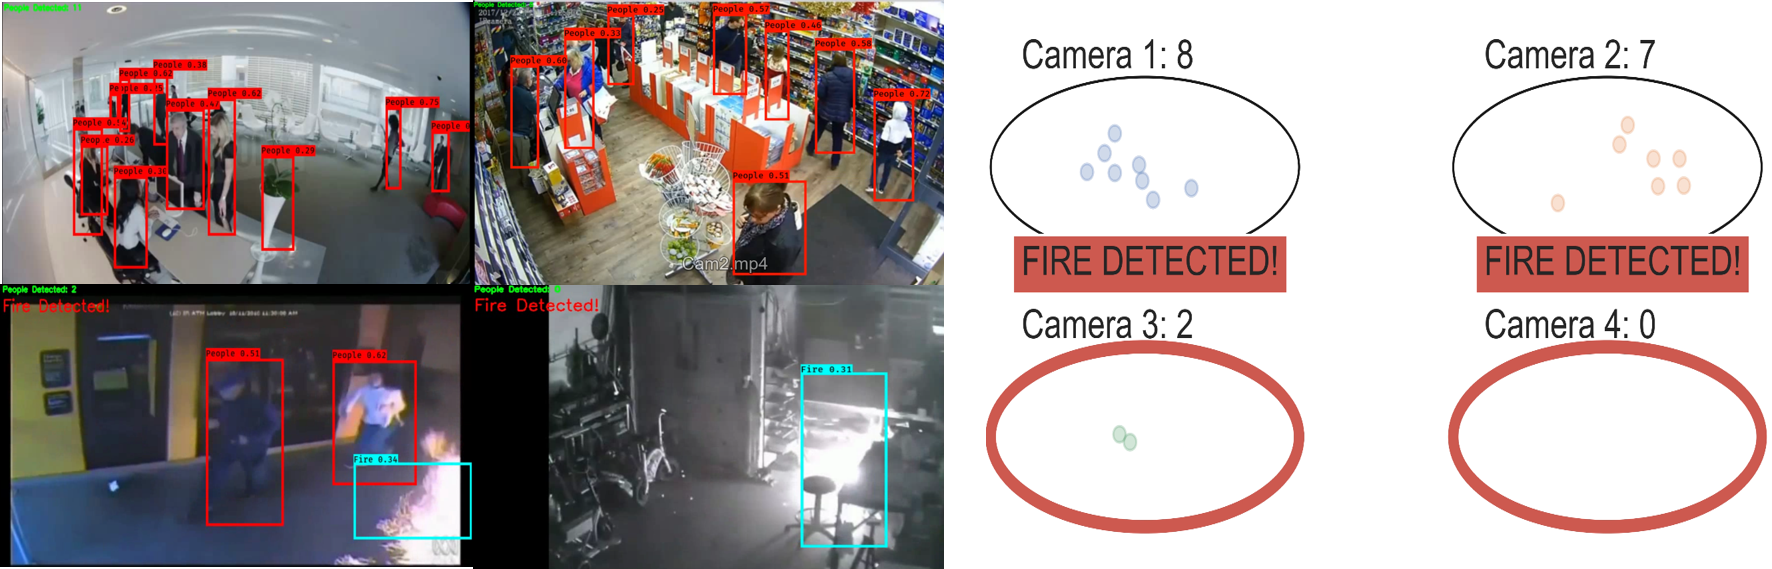

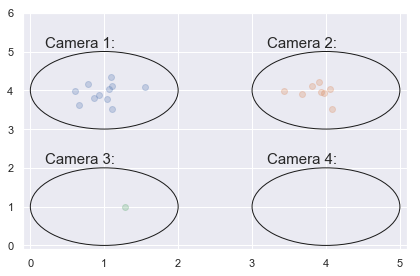

In [14]:
%matplotlib notebook
%matplotlib inline
from IPython.display import HTML
from matplotlib import animation, rc
import seaborn as sns
sns.set()
cam_count=np.vstack([cam1_array,cam2_array,cam3_array,cam4_array])
fire_count=np.vstack([fire1_array,fire2_array,fire3_array,fire4_array])

fig, ax = plt.subplots()


x1,y1 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[0,0]))
x2,y2 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[1,0]))
x3,y3 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[2,0]))
x4,y4 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[3,0]))


scat1=ax.scatter(x1,y1+3,alpha=0.25)
scat2=ax.scatter(x2+3,y2+3,alpha=0.25)
scat3=ax.scatter(x3,y3,alpha=0.25)
scat4=ax.scatter(x4+3,y4,alpha=0.25)

a_circle1 = plt.Circle((1, 1), 1,fill=False,edgecolor="k")
a_circle2 = plt.Circle((1, 4), 1,fill=False,edgecolor="k")
a_circle3 = plt.Circle((4, 1), 1,fill=False,edgecolor="k")
a_circle4 = plt.Circle((4, 4), 1,fill=False,edgecolor="k")

ax.text(0.2, 5.1, "Camera 1: ", fontsize=15)
ax.text(3.2, 5.1, "Camera 2: ", fontsize=15)
ax.text(0.2, 2.1, "Camera 3: ", fontsize=15)
ax.text(3.2, 2.1, "Camera 4: ", fontsize=15)


ax.add_artist(a_circle1)
ax.add_artist(a_circle2)
ax.add_artist(a_circle3)
ax.add_artist(a_circle4)

ax.set_xlim([-0.1,5.1])
ax.set_ylim([-0.1,6])

plt.tight_layout()
plt.show()

def init():
    x1,y1 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[0,0]))
    x2,y2 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[1,0]))
    x3,y3 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[2,0]))
    x4,y4 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[3,0]))


    scat1=ax.scatter(x1,y1+3,alpha=0.25)
    scat2=ax.scatter(x2+3,y2+3,alpha=0.25)
    scat3=ax.scatter(x3,y3,alpha=0.25)
    scat4=ax.scatter(x4+3,y4,alpha=0.25)

    a_circle1 = plt.Circle((1, 1), 1,fill=False,edgecolor="k")
    a_circle2 = plt.Circle((1, 4), 1,fill=False,edgecolor="k")
    a_circle3 = plt.Circle((4, 1), 1,fill=False,edgecolor="k")
    a_circle4 = plt.Circle((4, 4), 1,fill=False,edgecolor="k")

    ax.text(0.35, 5.1, "Camera 1: ", fontsize=15)
    ax.text(3.35, 5.1, "Camera 2: ", fontsize=15)
    ax.text(0.35, 2.1, "Camera 3: ", fontsize=15)
    ax.text(3.35, 2.1, "Camera 4: ", fontsize=15)


    ax.add_artist(a_circle1)
    ax.add_artist(a_circle2)
    ax.add_artist(a_circle3)
    ax.add_artist(a_circle4)

    ax.set_xlim([-0.01,5.1])
    ax.set_ylim([-0.1,5])
    
    return scat1,scat2,scat3,scat4,a_circle1 ,a_circle2 ,a_circle3 ,a_circle4 


def animate(i):
    
    global x1,x2,x3,x4,y1,y2,y3,y4
    
    
    ax.cla()
#     plt.clf()
    if i%2==0:
        x1,y1 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[0,i]))
        x2,y2 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[1,i]))
        x3,y3 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[2,i]))
        x4,y4 = np.random.normal(loc=1,scale=0.25,size=(2, cam_count[3,i]))

    scat1=ax.scatter(x1,y1+3,alpha=0.25)
    scat2=ax.scatter(x2+3,y2+3,alpha=0.25)
    scat3=ax.scatter(x3,y3,alpha=0.25)
    scat4=ax.scatter(x4+3,y4,alpha=0.25)

    if fire_count[0,i]>0:
        a_circle1 = plt.Circle((1, 4), 1,fill=False,edgecolor="r",linewidth=5)
        ax.text(0.2, 5.8, "FIRE DETECTED!", fontsize=15,bbox=dict(facecolor="r"))
    else:
        a_circle1 = plt.Circle((1, 4), 1,fill=False,edgecolor="k")
        
    if fire_count[1,i]>0:
        a_circle2 = plt.Circle((4, 4), 1,fill=False,edgecolor="r",linewidth=5)
        ax.text(3.2, 5.8, "FIRE DETECTED!", fontsize=15,bbox=dict(facecolor="r"))
    else:
        a_circle2 = plt.Circle((4, 4), 1,fill=False,edgecolor="k")
    
    if fire_count[2,i]>0:
        a_circle3 = plt.Circle((1, 1), 1,fill=False,edgecolor="r",linewidth=5)
        ax.text(0.2, 2.8, "FIRE DETECTED!", fontsize=15,bbox=dict(facecolor="r"))
    else:
        a_circle3 = plt.Circle((1, 1), 1,fill=False,edgecolor="k")  
    
    if fire_count[3,i]>0:
        a_circle4 = plt.Circle((4, 1), 1,fill=False,edgecolor="r",linewidth=5)
        ax.text(3.2, 2.8, "FIRE DETECTED!", fontsize=15,bbox=dict(facecolor="r"))
    else:
        a_circle4 = plt.Circle((4, 1), 1,fill=False,edgecolor="k")
    

    ax.text(0.2, 5.1, "Camera 1: "+ str(cam_count[0,i]), fontsize=15)
    ax.text(3.2, 5.1, "Camera 2: "+ str(cam_count[1,i]), fontsize=15)
    ax.text(0.2, 2.1, "Camera 3: "+ str(cam_count[2,i]), fontsize=15)
    ax.text(3.2, 2.1, "Camera 4: "+ str(cam_count[3,i]), fontsize=15)


    ax.add_artist(a_circle1)
    ax.add_artist(a_circle2)
    ax.add_artist(a_circle3)
    ax.add_artist(a_circle4)

    ax.set_xlim([-0.1,5.1])
    ax.set_ylim([-0.1,7])
    ax.grid(False)
    ax.axis('off')

    return scat1,scat2,scat3,scat4,a_circle1 ,a_circle2 ,a_circle3 ,a_circle4 
    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=cam_count.shape[1],blit=True) 
# # plt.show()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim.save('heatmap_circles.mp4', writer=writer,dpi=600)

# HTML(anim.to_jshtml())

### This Cell Imports api credentials from IBM to access cloud data

In [15]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError

cos_credentials={
  "apikey": "3ifDMUyTxwW7C30JlKVRdi5FpijnReisfUVLNwjPgFBj",
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key 6c04872e-5bc4-431d-b608-28492aa4955f",
  "iam_apikey_name": "cloud-annotations-binding",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/36c5a36d7ceb4e7690fc654b3802a2f9::serviceid:ServiceId-f43d7268-4c52-4dbd-b57b-d54ff7c7b1f2",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/36c5a36d7ceb4e7690fc654b3802a2f9:ac1d32d4-e472-487b-86e8-d53aef97a86e::"
}

auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

### This Cell Upload a Labeled Picture to IBM Cloud

(416, 416, 3)
Found 6 boxes for img
People 0.30 (294, 121) (374, 453)
People 0.33 (24, 191) (162, 640)
People 0.35 (1081, 425) (1293, 886)
People 0.37 (1084, 179) (1256, 534)
People 0.40 (852, 375) (1052, 888)
People 0.70 (760, 23) (858, 306)
Time spent: 0.232sec


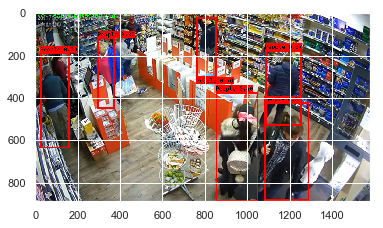

In [17]:
cos.download_file(Bucket='bucketods-test',Key='timestamp0227.png',Filename='timestamp0227.png')

counts=label_image('timestamp0227.png')
counts.to_json("timestamp0227.json")
cos.upload_file(Filename='timestamp0227.json',Bucket='bucketods-test',Key='mnist_test.csv')